### Tablas y Figuras

In [1]:
from sklearn.datasets import make_blobs
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from fkdc.main import clasificadores
from fkdc.tarea import Tarea
from fkdc.datasets import Dataset

import os
import pickle

os.getcwd()
from pathlib import Path

main_seed = 1732373523
# main_seed = 3179636698

root_dir = Path("/Users/gonzalo/Git/fkdc")
data_dir = root_dir / "docs/data"
data_dir.mkdir(exist_ok=True)
img_dir = root_dir / "docs/img"
run_dir = root_dir / ("runs/run-%i" % main_seed)

2024-10-29 19:20:24,234 - fkdc.main - INFO - Logging inicializado
2024-10-29 19:20:24,236 - fkdc.main - INFO - Instanciando clasificadores y grillas
2024-10-29 19:20:24,238 - fkdc.main - INFO - Instanciando datasets


NameError: name 'run_seeds' is not defined

In [148]:
seeds = pickle.load(open(run_dir / ("%i-run_seeds.pkl" % main_seed), "rb"))``

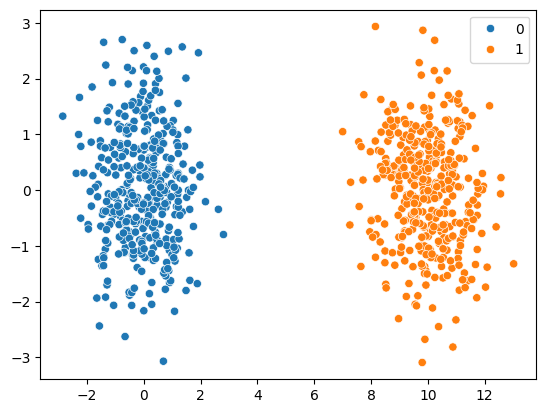

In [100]:
seed = 1984
ds = Dataset.de_fabrica(
    make_blobs,
    n_samples=(400, 400),
    n_features=2,
    centers=((0, 0), (10, 0)),
    random_state=seed,
)
ds.scatter()

In [101]:
run_2blobs = run_dir / f"../2blobs-{seed}.pkl"
if run_2blobs.exists():
    tarea = pickle.load(open(run_2blobs, "rb"))
else:
    tarea = Tarea(ds, clasificadores, seed=seed)
    tarea.entrenar()
    tarea.evaluar()
    tarea.guardar(run_2blobs)

In [102]:
campos = {"logvero": "$cal(l)$", "r2": "$R^2$", "accuracy": "exac"}
tabla = pd.DataFrame(tarea.info).T[campos.keys()].rename(columns=campos).astype(float)
tabla.index = "#" + tabla.index
tabla

,$cal(l)$,$R^2$,exac
#fkdc,-3.552714e-14,1.000000,1.0000
#kdc,-3.552714e-14,1.000000,1.0000
#gnb,-1.450418e-11,1.000000,1.0000
#kn,-3.552714e-14,1.000000,1.0000
#fkn,-3.552714e-14,1.000000,1.0000
#lr,-4.567819e+00,0.958906,1.0000
#svc,NaN,NaN,1.0000
#lsvc,NaN,NaN,1.0000
#base,-1.111567e+02,0.000000,0.4625


In [103]:
tabla.round(4).to_csv(data_dir / "2-blobs.csv")

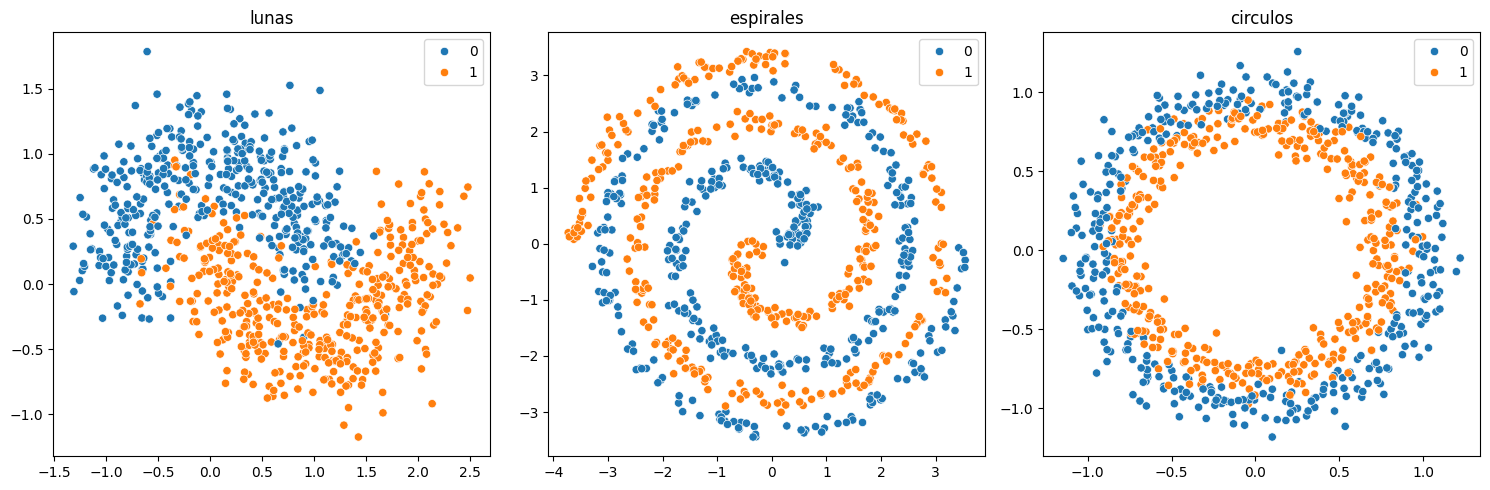

In [104]:
import pickle

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
seed = 4107
datasets_2d = ["lunas", "espirales", "circulos"]
for nombre, ax in zip(datasets_2d, axs):
    ds = pickle.load(open(run_dir / f"dataset-('{nombre}', {seed}, 'lo').pkl", "rb"))
    ds.scatter(ax=ax)
    ax.set_title(nombre)
plt.tight_layout()
fig.savefig(img_dir / "datasets-lunas-circulos-espirales.svg")

In [106]:
infos = {
    (nombre, seed): pickle.load(
        open(run_dir / f"info-('{nombre}', {seed}, 'lo').pkl", "rb")
    )
    for seed in seeds
    for nombre in datasets_2d
}

In [107]:
exacs = {k: pd.DataFrame(info).loc["accuracy"] for k, info in infos.items()}
exacs = (
    pd.DataFrame(exacs)
    .T.melt(ignore_index=False, var_name="clf", value_name="exac")
    .reset_index(names=["dataset", "semilla"])
)
exacs["exac"] = exacs.exac.astype(float)
exacs

,dataset,semilla,clf,exac
0,lunas,4107,fkdc,0.9375
1,espirales,4107,fkdc,0.9850
2,circulos,4107,fkdc,0.8575
3,lunas,4479,fkdc,0.9175
4,espirales,4479,fkdc,0.9750
...,...,...,...,...
427,espirales,3924,base,0.4900
428,circulos,3924,base,0.4750
429,lunas,1115,base,0.4975
430,espirales,1115,base,0.4900


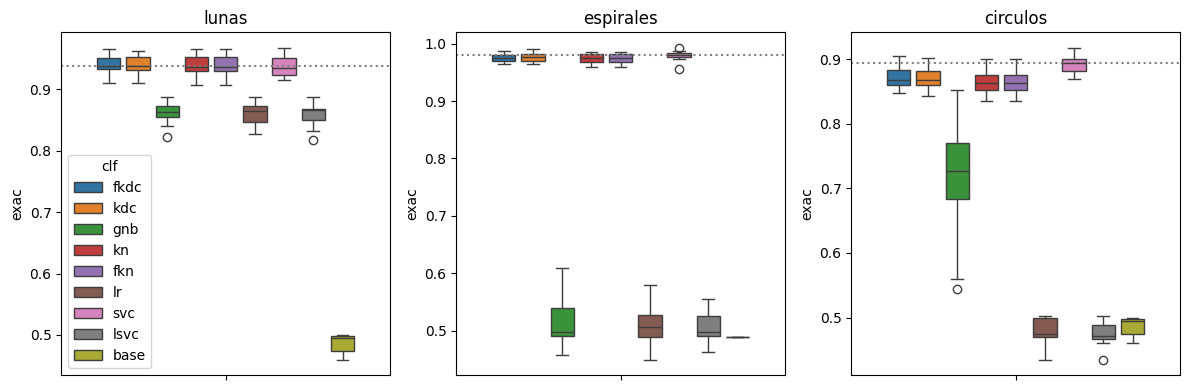

In [108]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
seed = 4107
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = exacs.query("dataset == @nombre")
    sns.boxplot(data, hue="clf", y="exac", gap=0.2, ax=ax)
    ax.set_title(nombre)
    ax.axhline(
        data.groupby("clf").exac.median().max(), linestyle="dotted", color="gray"
    )
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos.svg")

In [109]:
tabla = (
    exacs.groupby(["dataset", "clf"])
    .exac.agg(["mean", "std"])
    .reset_index()
    .pivot(index="clf", columns="dataset", values=["mean", "std"])
)
tabla.columns = tabla.columns.reorder_levels([1, 0])

In [110]:
tabla = tabla.apply(lambda x: round(100 * x, 2))[tabla.columns.sortlevel()[0]].round(2)
tabla.to_csv(data_dir / "exac-ds-2d.csv")
tabla

dataset circulos       espirales        lunas      
            mean   std      mean   std   mean   std
clf                                                
base       48.61  1.42     49.00  0.00  48.61  1.42
fkdc       87.17  1.64     97.53  0.66  94.00  1.49
fkn        86.59  1.65     97.47  0.79  93.95  1.51
gnb        71.95  9.41     51.36  3.87  86.16  1.62
kdc        87.11  1.76     97.72  0.80  94.05  1.49
kn         86.59  1.65     97.47  0.79  93.95  1.51
lr         48.03  1.94     51.05  3.52  86.05  1.65
lsvc       47.50  1.70     50.61  2.56  85.91  1.90
svc        89.33  1.53     97.88  0.83  93.73  1.76

In [111]:
rsqs = {k: pd.DataFrame(info).loc["r2"] for k, info in infos.items()}
rsqs = (
    pd.DataFrame(rsqs)
    .T.melt(ignore_index=False, var_name="clf", value_name="r2")
    .reset_index(names=["dataset", "semilla"])
)
rsqs["r2"] = rsqs.r2.astype(float)
rsqs

,dataset,semilla,clf,r2
0,lunas,4107,fkdc,0.667312
1,espirales,4107,fkdc,0.365714
2,circulos,4107,fkdc,0.570022
3,lunas,4479,fkdc,0.719554
4,espirales,4479,fkdc,0.158191
...,...,...,...,...
427,espirales,3924,base,0.000000
428,circulos,3924,base,0.000000
429,lunas,1115,base,0.000000
430,espirales,1115,base,0.000000


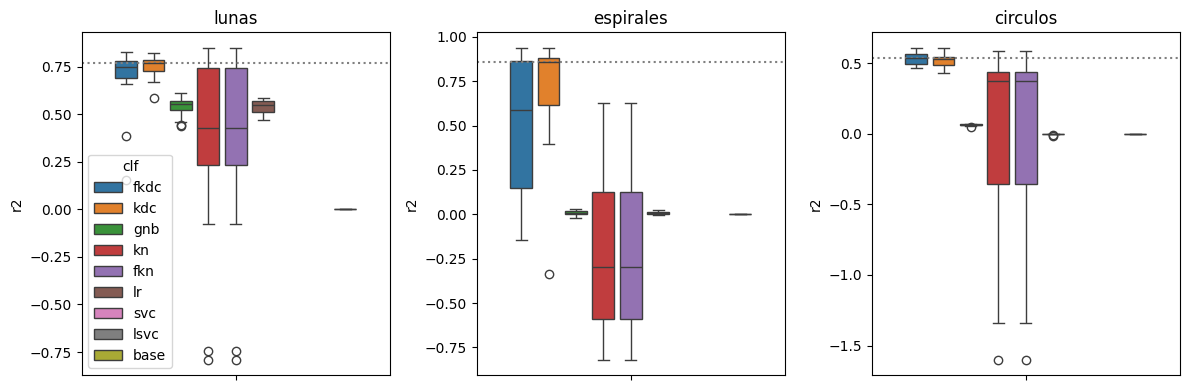

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
seed = 4107
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = rsqs.query("dataset == @nombre")
    sns.boxplot(data, hue="clf", y="r2", gap=0.2, ax=ax)
    ax.set_title(nombre)
    ax.axhline(
        data.groupby("clf").r2.median().max(), linestyle="dotted", color="gray"
    )
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-r2-lunas-espirales-circulos.svg")

In [113]:
tabla = (
    rsqs.groupby(["dataset", "clf"])
    .r2.agg(["mean", "std"])
    .reset_index()
    .pivot(index="clf", columns="dataset", values=["mean", "std"])
)
tabla.columns = tabla.columns.reorder_levels([1, 0])

In [114]:
tabla = tabla[tabla.columns.sortlevel()[0]].round(3).dropna()
tabla.to_csv(data_dir / "r2-ds-2d.csv")
tabla

dataset circulos        espirales         lunas       
            mean    std      mean    std   mean    std
clf                                                   
base       0.000  0.000     0.000  0.000  0.000  0.000
fkdc       0.533  0.044     0.496  0.409  0.690  0.177
fkn       -0.055  0.739    -0.209  0.420  0.340  0.509
gnb        0.063  0.006     0.008  0.012  0.538  0.053
kdc        0.518  0.050     0.710  0.323  0.748  0.062
kn        -0.055  0.739    -0.209  0.420  0.340  0.509
lr        -0.002  0.004     0.009  0.009  0.540  0.039

In [115]:
infos.keys()

dict_keys([('lunas', 4107), ('espirales', 4107), ('circulos', 4107), ('lunas', 4479), ('espirales', 4479), ('circulos', 4479), ('lunas', 5603), ('espirales', 5603), ('circulos', 5603), ('lunas', 5303), ('espirales', 5303), ('circulos', 5303), ('lunas', 4664), ('espirales', 4664), ('circulos', 4664), ('lunas', 9519), ('espirales', 9519), ('circulos', 9519), ('lunas', 9142), ('espirales', 9142), ('circulos', 9142), ('lunas', 4915), ('espirales', 4915), ('circulos', 4915), ('lunas', 4537), ('espirales', 4537), ('circulos', 4537), ('lunas', 7381), ('espirales', 7381), ('circulos', 7381), ('lunas', 7761), ('espirales', 7761), ('circulos', 7761), ('lunas', 7648), ('espirales', 7648), ('circulos', 7648), ('lunas', 8446), ('espirales', 8446), ('circulos', 8446), ('lunas', 3919), ('espirales', 3919), ('circulos', 3919), ('lunas', 3924), ('espirales', 3924), ('circulos', 3924), ('lunas', 1115), ('espirales', 1115), ('circulos', 1115)])

In [116]:
tarea = pickle.load(open(run_dir / f"tarea-('circulos', 4107, 'lo').pkl", "rb"))

In [117]:
seeds

array([4107, 4479, 5603, 5303, 4664, 9519, 9142, 4915, 4537, 7381, 7761,
       7648, 8446, 3919, 3924, 1115])

In [118]:
corrida = ("circulos", 4479)
df = pd.concat(
    {
        est: pd.DataFrame(infos[corrida][est].busqueda.cv_results_)
        for est in ("kdc", "fkdc")
    }, names=["est", "index"]
).reset_index()

In [119]:
coso = df.query("est == 'kdc'").param_alpha.unique()[0]

In [120]:
df.groupby("est").param_alpha.agg(lambda x: x.isna().mean())

est
fkdc    0.0
kdc     1.0
Name: param_alpha, dtype: float64

In [121]:
import numpy as np

In [122]:
df[df.param_alpha.isna() | (df.param_alpha == 1)].groupby(
    ["est", "param_alpha"], dropna=False
).size()

est   param_alpha
fkdc  1.0             21
kdc   NaN            101
dtype: int64

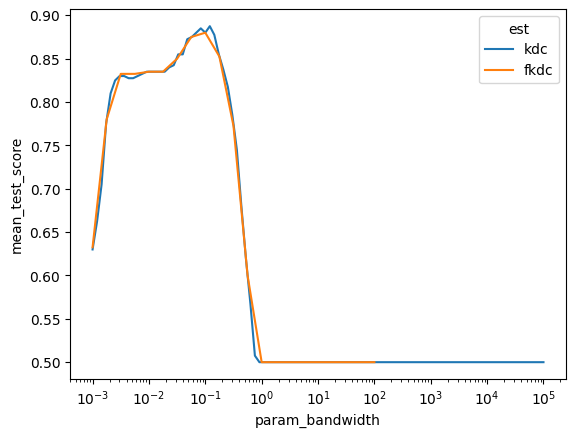

In [123]:
sns.lineplot(
    df[(df.est == "kdc") | ((df.est == "fkdc") & (df.param_alpha == 1))],
    y="mean_test_score",
    x="param_bandwidth",
    hue="est",
)
plt.xscale("log")

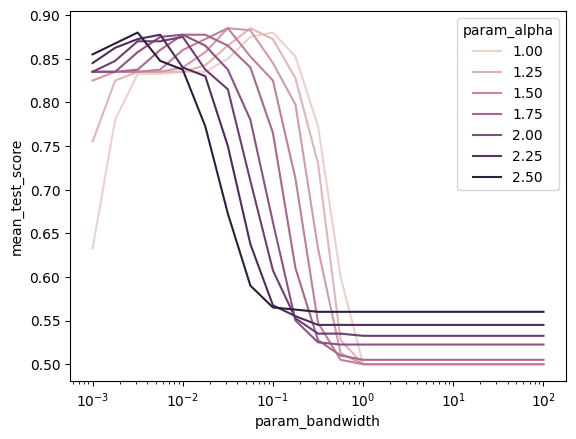

In [124]:
sns.lineplot(
    df[(df.est == "fkdc")],
    y="mean_test_score",
    x="param_bandwidth",
    hue="param_alpha",
)
plt.xscale("log")

In [125]:
data = df[(df.est == "fkdc")].pivot(index="param_alpha", columns="param_bandwidth", values="mean_test_score")
X = data.columns.values
Y = data.index.values
Z = data.values

In [126]:
df[df.rank_test_score == 1].filter(like="param_")

,param_bandwidth,param_alpha
26,0.120226,NaN
129,0.056234,1.1875
149,0.031623,1.375
170,0.031623,1.5625


In [127]:
infos[corrida].fkdc.busqueda.best_params_

{'alpha': 1.1875, 'bandwidth': 0.05623413251903491}

In [128]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [129]:
data = {
    "corrida": corrida,
    "best_params": {
        est: info.busqueda.best_params_
        for est, info in infos[corrida].items()
        if est != "base"
    },
    "exac": {
        est: info.accuracy
        for est, info in infos[corrida].items()
        if est != "base"
    }
}

In [130]:
dumped = json.dumps(data, cls=NumpyEncoder)

with open(data_dir / f"best_params-2d-lo.json", "w") as f:
    json.dump(dumped, f)

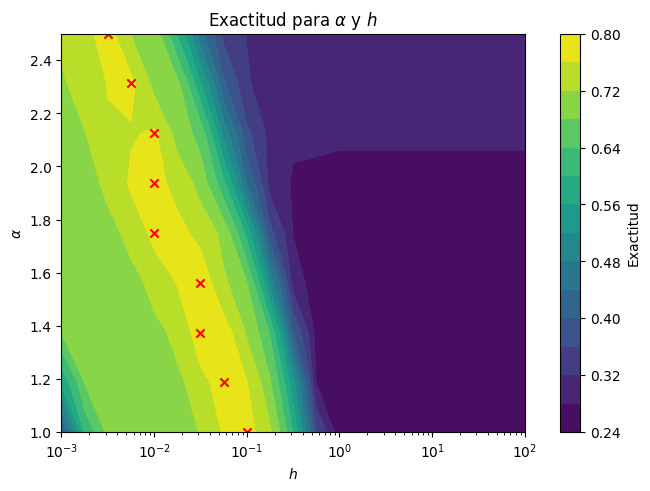

In [131]:
from matplotlib import colors

fig, ax = plt.subplots(layout="constrained")
zmin, zmax = Z.min(), Z.max()
CS = ax.contourf(X, Y, Z**2, 15, cmap="viridis")
ax.set_title("Exactitud para $\\alpha$ y $h$")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")
ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Exactitud")
ax.set_xscale("log")
# plt.tight_layout()
fig.savefig(img_dir / "heatmap-fkdc-2d-lo.svg")

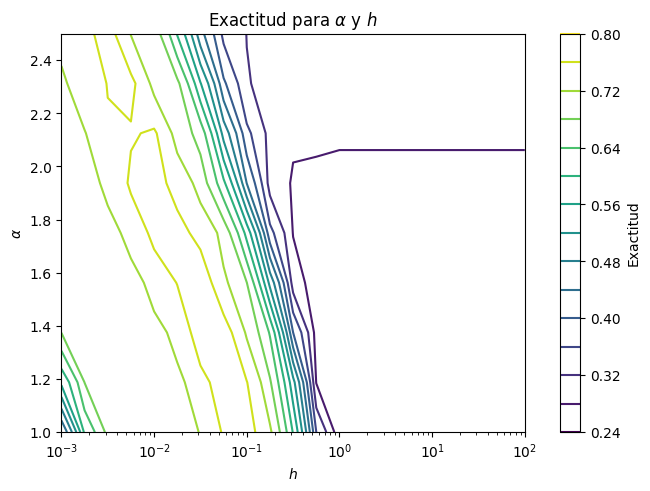

In [132]:
from matplotlib import colors

fig, ax = plt.subplots(layout='constrained')
zmin, zmax = Z.min(), Z.max()
CS = ax.contour(X, Y, Z**2, 15, cmap="viridis")
ax.set_title('Exactitud para $\\alpha$ y $h$')
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Exactitud')
plt.xscale("log")

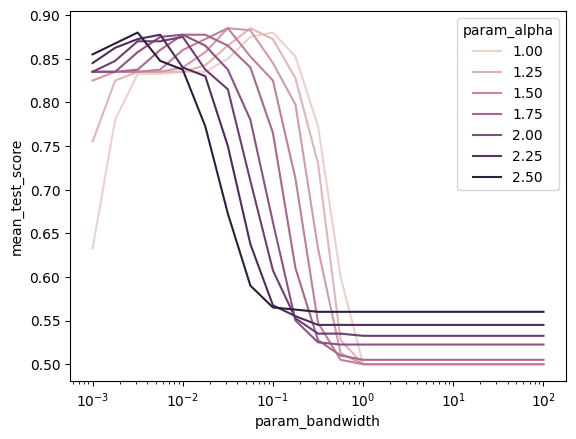

In [133]:
sns.lineplot(
    df[(df.est == "fkdc")],
    y="mean_test_score",
    x="param_bandwidth",
    hue="param_alpha",
)
plt.xscale("log")

In [134]:
some_seeds = [5303, 1115, 7761]

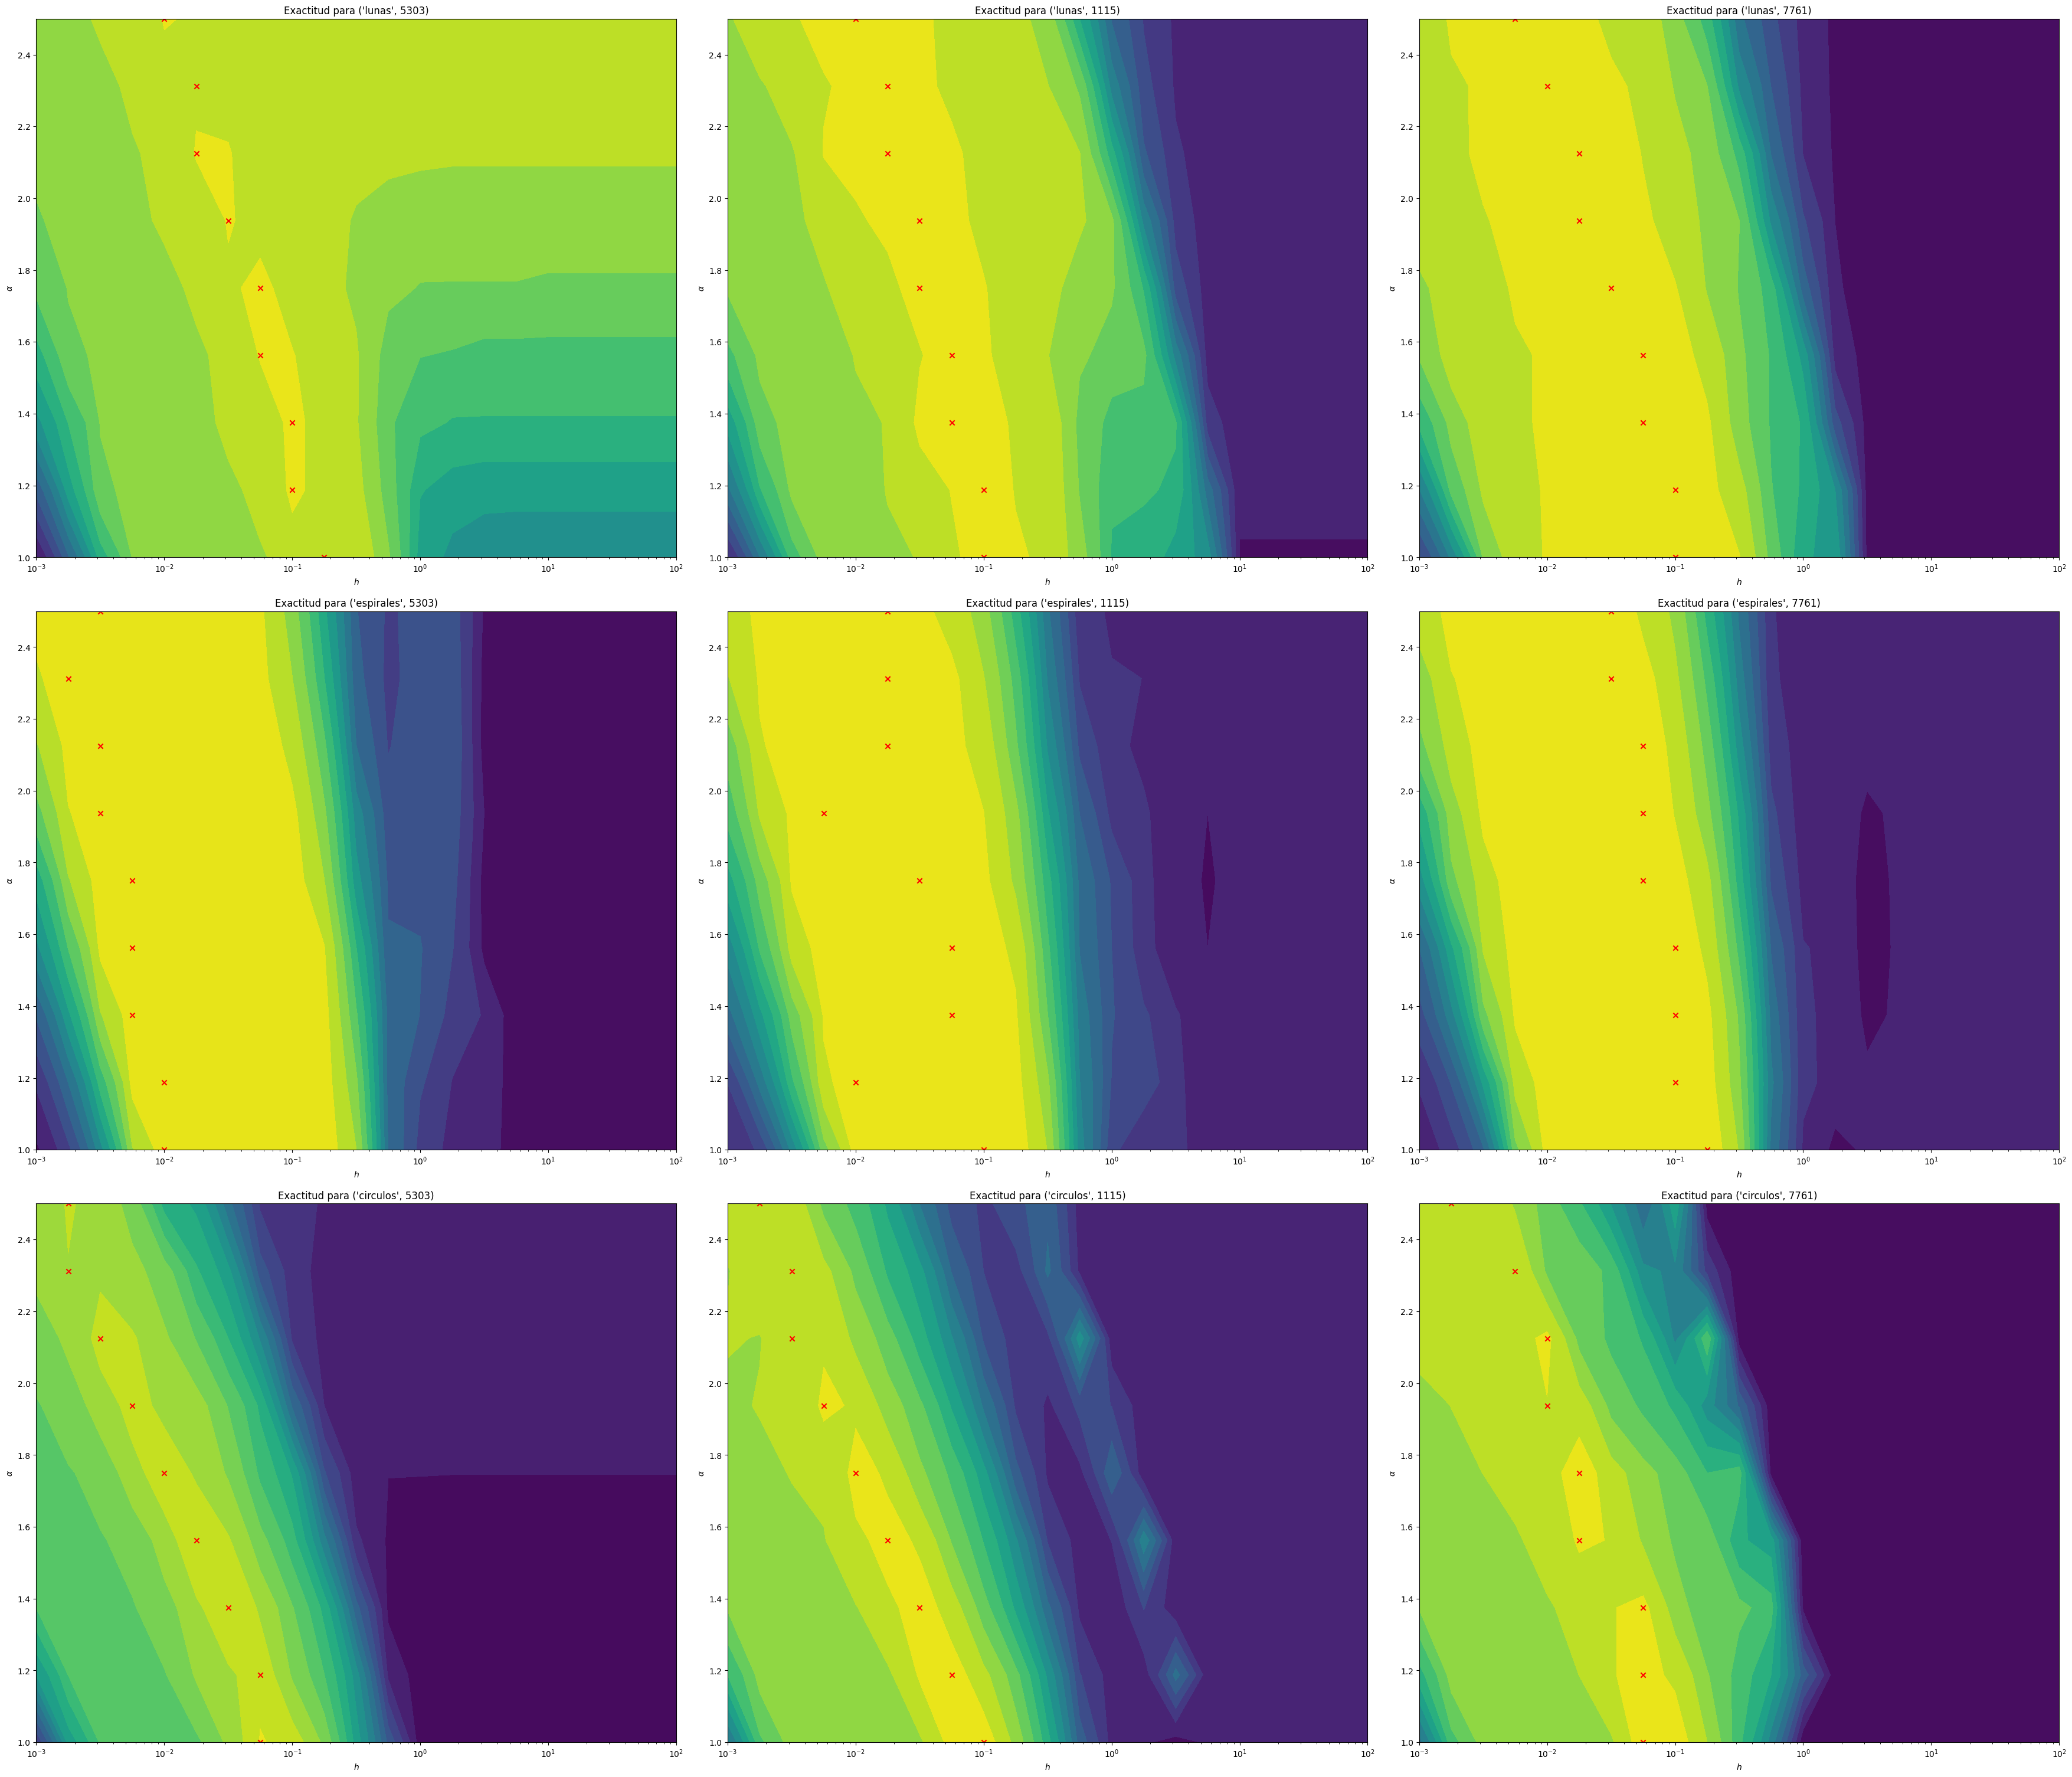

In [135]:
from matplotlib import colors
from itertools import product

fig, axs = plt.subplots(3, 3, figsize=(35, 30), layout="constrained")
for corrida, ax in zip(product(datasets_2d, some_seeds), axs.flatten()):
    df = pd.concat(
        {
            est: pd.DataFrame(infos[corrida][est].busqueda.cv_results_)
            for est in ("kdc", "fkdc")
        },
        names=["est", "index"],
    ).reset_index()
    coso = df.query("est == 'kdc'").param_alpha.unique()[0]
    data = df[(df.est == "fkdc")].pivot(
        index="param_alpha", columns="param_bandwidth", values="mean_test_score"
    )
    X = data.columns.values
    Y = data.index.values
    Z = data.values
    zmin, zmax = Z.min(), Z.max()
    CS = ax.contourf(X, Y, Z**2, 15, cmap="viridis")
    ax.set_title(f"Exactitud para {corrida}")
    ax.set_xlabel("$h$")
    ax.set_ylabel("$\\alpha$")
    ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
    # Make a colorbar for the ContourSet returned by the contourf call.
    # cbar = fig.colorbar(CS)
    # cbar.ax.set_ylabel("Exactitud")
    ax.set_xscale("log")
    # plt.tight_layout()
fig.savefig(img_dir / "many-heatmaps-fkdc-2d-lo.svg")

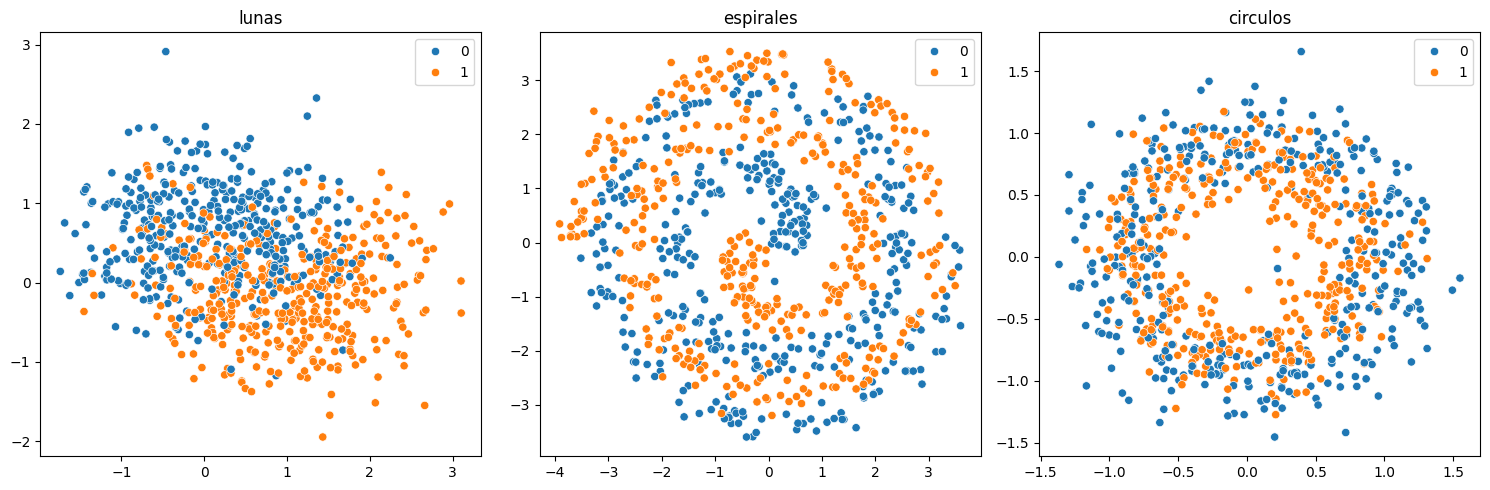

In [136]:
import pickle

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
seed = 4107
datasets_2d = ["lunas", "espirales", "circulos"]
for nombre, ax in zip(datasets_2d, axs):
    ds = pickle.load(open(run_dir / f"dataset-('{nombre}', {seed}, 'hi').pkl", "rb"))
    ds.scatter(ax=ax)
    ax.set_title(nombre)
plt.tight_layout()
fig.savefig(img_dir / "datasets-lunas-circulos-espirales-hi.svg")

In [137]:
infos = {
    (nombre, seed): pickle.load(
        open(run_dir / f"info-('{nombre}', {seed}, 'hi').pkl", "rb")
    )
    for seed in seeds
    for nombre in datasets_2d
}

In [138]:
exacs = {k: pd.DataFrame(info).loc["accuracy"] for k, info in infos.items()}
exacs = (
    pd.DataFrame(exacs)
    .T.melt(ignore_index=False, var_name="clf", value_name="exac")
    .reset_index(names=["dataset", "semilla"])
)
exacs["exac"] = exacs.exac.astype(float)
exacs

,dataset,semilla,clf,exac
0,lunas,4107,fkdc,0.7900
1,espirales,4107,fkdc,0.8475
2,circulos,4107,fkdc,0.6325
3,lunas,4479,fkdc,0.7900
4,espirales,4479,fkdc,0.8625
...,...,...,...,...
427,espirales,3924,base,0.4900
428,circulos,3924,base,0.4750
429,lunas,1115,base,0.4975
430,espirales,1115,base,0.4900


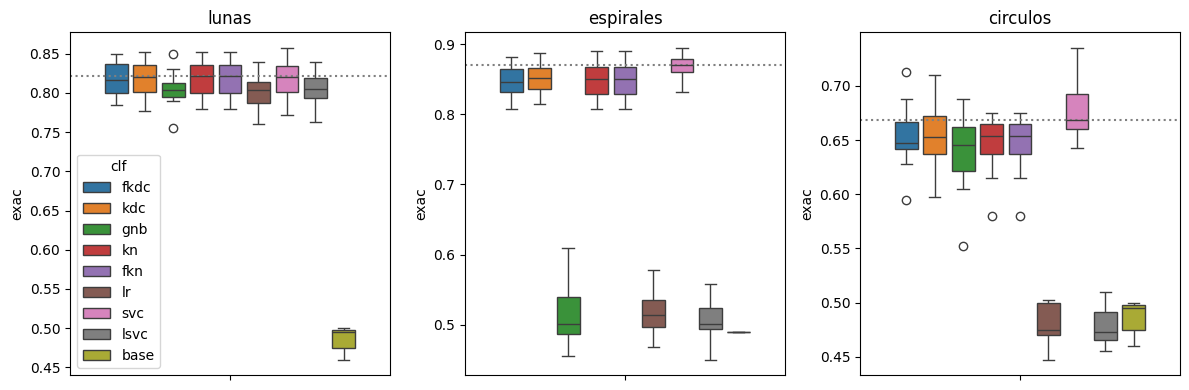

In [139]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = exacs.query("dataset == @nombre")
    sns.boxplot(data, hue="clf", y="exac", gap=0.2, ax=ax)
    ax.set_title(nombre)
    ax.axhline(
        data.groupby("clf").exac.median().max(), linestyle="dotted", color="gray"
    )
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-hi.svg")

In [140]:
tabla = (
    exacs.groupby(["dataset", "clf"])
    .exac.agg(["mean", "std"])
    .reset_index()
    .pivot(index="clf", columns="dataset", values=["mean", "std"])
)
tabla.columns = tabla.columns.reorder_levels([1, 0])

In [141]:
tabla = tabla.apply(lambda x: round(100 * x, 2))[tabla.columns.sortlevel()[0]].round(2)
tabla.to_csv(data_dir / "exac-ds-2d.csv")
tabla

dataset circulos       espirales        lunas      
            mean   std      mean   std   mean   std
clf                                                
base       48.61  1.42     49.00  0.00  48.61  1.42
fkdc       65.31  2.79     84.88  2.18  81.70  2.22
fkn        64.69  2.46     84.97  2.57  81.86  2.29
gnb        63.98  3.37     51.41  4.00  80.50  2.10
kdc        65.38  2.98     85.09  2.21  81.80  2.44
kn         64.69  2.46     84.97  2.57  81.86  2.29
lr         48.12  1.74     51.88  3.01  80.25  2.17
lsvc       47.86  1.79     50.55  2.68  80.52  1.99
svc        67.80  2.60     86.80  1.82  82.02  2.44

In [142]:
rsqs = {k: pd.DataFrame(info).loc["r2"] for k, info in infos.items()}
rsqs = (
    pd.DataFrame(rsqs)
    .T.melt(ignore_index=False, var_name="clf", value_name="r2")
    .reset_index(names=["dataset", "semilla"])
)
rsqs["r2"] = rsqs.r2.astype(float)
rsqs

,dataset,semilla,clf,r2
0,lunas,4107,fkdc,0.362506
1,espirales,4107,fkdc,0.543080
2,circulos,4107,fkdc,0.090811
3,lunas,4479,fkdc,0.292212
4,espirales,4479,fkdc,-0.128184
...,...,...,...,...
427,espirales,3924,base,0.000000
428,circulos,3924,base,0.000000
429,lunas,1115,base,0.000000
430,espirales,1115,base,0.000000


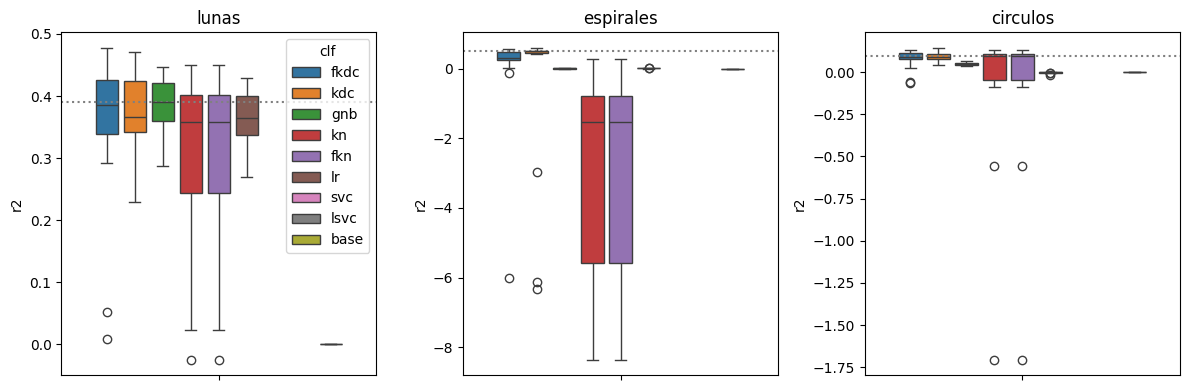

In [143]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
seed = 4107
for idx, nombre in enumerate(datasets_2d):
    ax = axs[idx]
    data = rsqs.query("dataset == @nombre")
    sns.boxplot(data, hue="clf", y="r2", gap=0.2, ax=ax)
    ax.set_title(nombre)
    ax.axhline(
        data.groupby("clf").r2.median().max(), linestyle="dotted", color="gray"
    )
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-r2-lunas-espirales-circulos-hi.svg")

In [144]:
tabla = (
    rsqs.groupby(["dataset", "clf"])
    .r2.agg(["mean", "std"])
    .reset_index()
    .pivot(index="clf", columns="dataset", values=["mean", "std"])
)
tabla.columns = tabla.columns.reorder_levels([1, 0])

In [145]:
tabla = tabla[tabla.columns.sortlevel()[0]].round(3).dropna()
tabla.to_csv(data_dir / "r2-ds-2d.csv")
tabla

dataset circulos        espirales         lunas       
            mean    std      mean    std   mean    std
clf                                                   
base       0.000  0.000     0.000  0.000  0.000  0.000
fkdc       0.077  0.061    -0.067  1.596  0.347  0.133
fkn       -0.082  0.465    -3.081  3.123  0.299  0.153
gnb        0.050  0.009     0.007  0.012  0.384  0.045
kdc        0.094  0.026    -0.556  2.374  0.374  0.060
kn        -0.082  0.465    -3.081  3.123  0.299  0.153
lr        -0.002  0.004     0.009  0.009  0.364  0.044

In [8]:
def get_seeds(main_seed):
    run_dir = root_dir / ("runs/run-%i" % main_seed)
    return pickle.load(open(run_dir / ("%i-run_seeds.pkl" % main_seed), "rb"))


def list_items(run_dir, kind):
    root = f"{kind}-"
    paths = run_dir.glob(f"{root}*.pkl")
    return {eval(p.stem.lstrip(root)): pickle.load(open(p, "rb")) for p in paths}


def list_infos(run_dir):
    return list_items(run_dir, "info")

In [9]:
seeds = get_seeds(main_seed)
run_dir = root_dir / ("runs/run-%i" % main_seed)
infos = list_infos(root_dir / ("runs/run-%i" % main_seed))

In [32]:
datasets_2d.keys()

dict_keys([('lunas', 8649, 'lo'), ('lunas', 6421, 'lo'), ('lunas', 3529, 'lo'), ('lunas', 3881, 'lo'), ('lunas', 7376, 'lo'), ('lunas', 2633, 'lo'), ('lunas', 7550, 'lo'), ('lunas', 3832, 'lo'), ('lunas', 6331, 'lo'), ('lunas', 2157, 'lo'), ('lunas', 4627, 'lo'), ('lunas', 6042, 'lo'), ('lunas', 1178, 'lo'), ('lunas', 9550, 'lo'), ('lunas', 5469, 'lo'), ('lunas', 2177, 'lo'), ('lunas', 8649, 'hi'), ('lunas', 6421, 'hi'), ('lunas', 3529, 'hi'), ('lunas', 3881, 'hi'), ('lunas', 7376, 'hi'), ('lunas', 2633, 'hi'), ('lunas', 7550, 'hi'), ('lunas', 3832, 'hi'), ('lunas', 6331, 'hi'), ('lunas', 2157, 'hi'), ('lunas', 4627, 'hi'), ('lunas', 6042, 'hi'), ('lunas', 1178, 'hi'), ('lunas', 9550, 'hi'), ('lunas', 5469, 'hi'), ('lunas', 2177, 'hi'), ('circulos', 8649, 'lo'), ('circulos', 6421, 'lo'), ('circulos', 3529, 'lo'), ('circulos', 3881, 'lo'), ('circulos', 7376, 'lo'), ('circulos', 2633, 'lo'), ('circulos', 7550, 'lo'), ('circulos', 3832, 'lo'), ('circulos', 6331, 'lo'), ('circulos', 2157, 

In [33]:
from fkdc.main import datasets_2d

ds = datasets_2d[('espirales', 3881, 'hi')]

In [34]:
from sklearn.utils import Bunch


tarea_logloss = Tarea(
    ds,
    clasificadores,
    busqueda_params=Bunch(
        refit=True, return_train_score=True, cv=5, scoring="neg_log_loss"
    ),
    split_evaluacion=0.5,
)
tarea_accuracy = Tarea(
    ds,
    clasificadores,
    busqueda_params=Bunch(
        refit=True, return_train_score=True, cv=5, scoring="accuracy"
    ),
    split_evaluacion=0.5,
)

In [35]:
tarea_logloss.entrenar()

2024-10-18 19:40:23,289 - fkdc.tarea - INFO - Entrenando kn
2024-10-18 19:40:24,013 - fkdc.tarea - INFO - Entrenando fkn


In [36]:
tarea_accuracy.entrenar()

2024-10-18 19:41:13,132 - fkdc.tarea - INFO - Entrenando kn
2024-10-18 19:41:14,630 - fkdc.tarea - INFO - Entrenando fkn


In [37]:
tarea_logloss.evaluar()
tarea_accuracy.evaluar()

2024-10-18 19:42:09,528 - fkdc.tarea - INFO - Evaluando kn
2024-10-18 19:42:09,535 - fkdc.tarea - INFO - Evaluando fkn
2024-10-18 19:42:09,620 - fkdc.tarea - INFO - Evaluando kn
2024-10-18 19:42:09,630 - fkdc.tarea - INFO - Evaluando fkn


In [38]:
pd.DataFrame(tarea_accuracy.info).T[["r2", "logvero", "accuracy"]]

,r2,logvero,accuracy
kn,-8.225508,-2559.099391,0.8225
fkn,-8.225508,-2559.099391,0.8225
base,0,-277.393884,0.4925


In [39]:
pd.DataFrame(tarea_logloss.info).T[["r2", "logvero", "accuracy"]]

,r2,logvero,accuracy
kn,0.225479,-215.905824,0.8175
fkn,0.225479,-215.905824,0.8175
base,0,-278.760333,0.475


In [ ]:
data = {
    "corrida": corrida,
    "best_params": {
        est: info.busqueda.best_params_
        for est, info in infos[corrida].items()
        if est != "base"
    },
    "exac": {
        est: info.accuracy
        for est, info in infos[corrida].items()
        if est != "base"
    }
}

In [ ]:
{}

In [195]:

busqueda_params = Bunch(refit=True, return_train_score=True, cv=5, scoring="log_loss")

In [196]:
Tarea

'log_loss'

In [186]:
infos[("lunas", get_seeds(main_seed)[0], "lo")].fkn.busqueda.get_params()["param_grid"]

{'n_neighbors': array([  1,   2,   3,   5,   7,  11,  17,  26,  39,  58,  88, 132, 199,
        300]),
 'weights': ['uniform', 'distance'],
 'alpha': array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ])}

In [160]:
p = next(info_paths)

In [165]:
eval(p.stem.lstrip("info-"))

('lunas', 2633, 'lo')

## Tomados de otros notebooks

### Decision Boundary Display

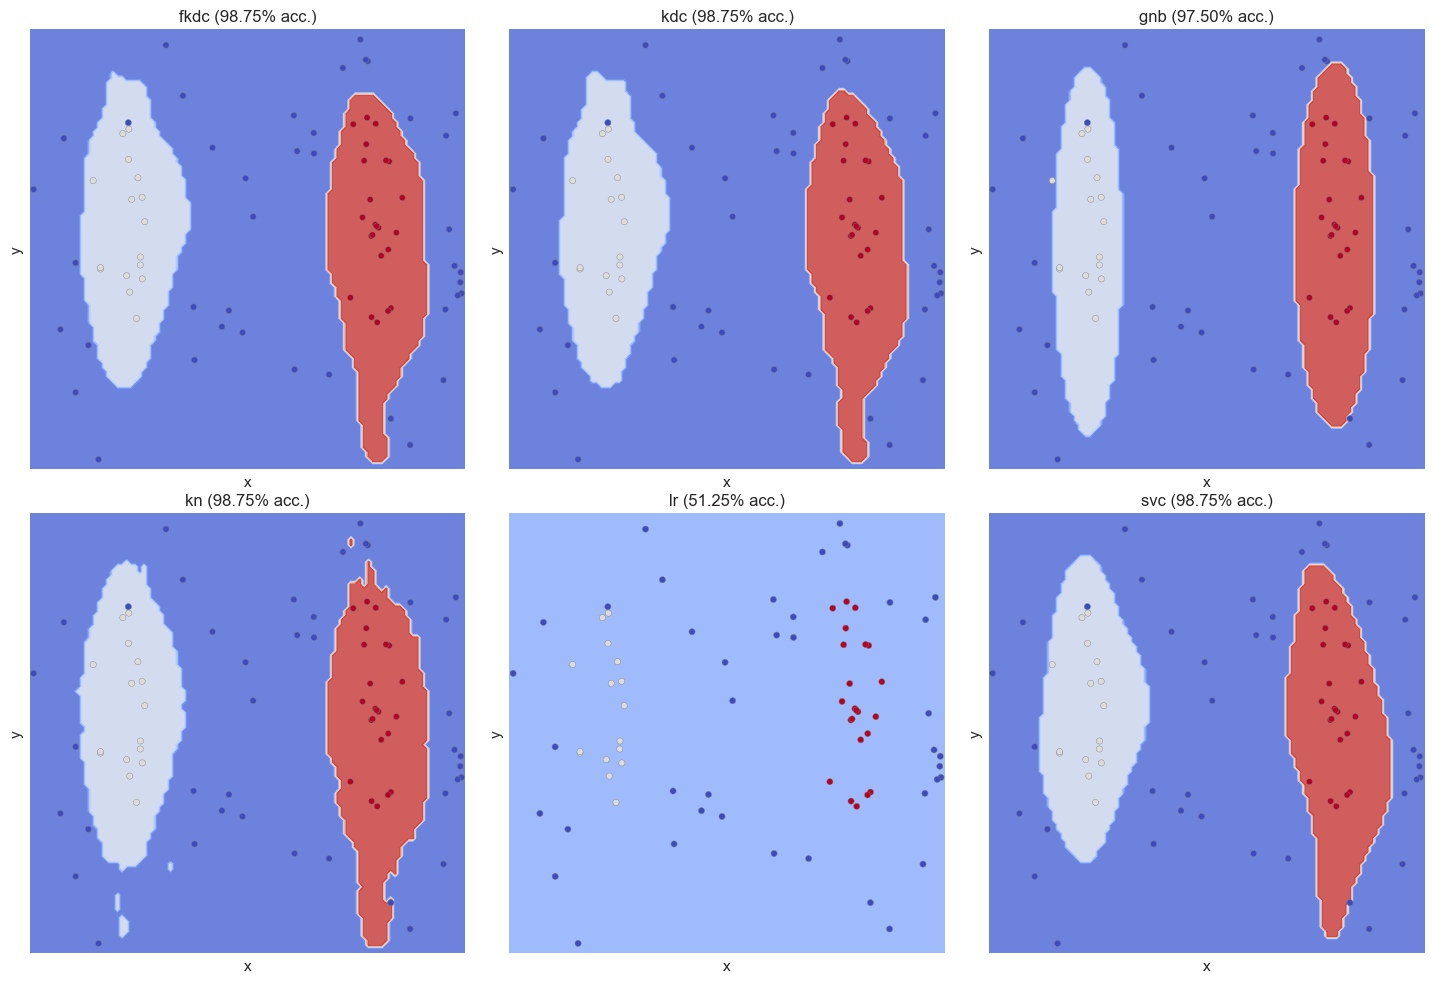

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

# Set-up 2x2 grid for plotting.
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

X = tarea.X_eval
y = tarea.y_eval
X0, X1 = X[:, 0], X[:, 1]

for (nombre, clf), ax in zip(tarea.clasificadores.items(), axs.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        eps=0.05,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="x",c
        ylabel="y",
    )
    ax.scatter(X0, X1, c=y.astype(float), cmap=plt.cm.coolwarm, s=20, edgecolors="gray")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f"{nombre} ({tarea.puntajes[nombre] * 100:.2f}% acc.)")

plt.show()

### Pair Plot

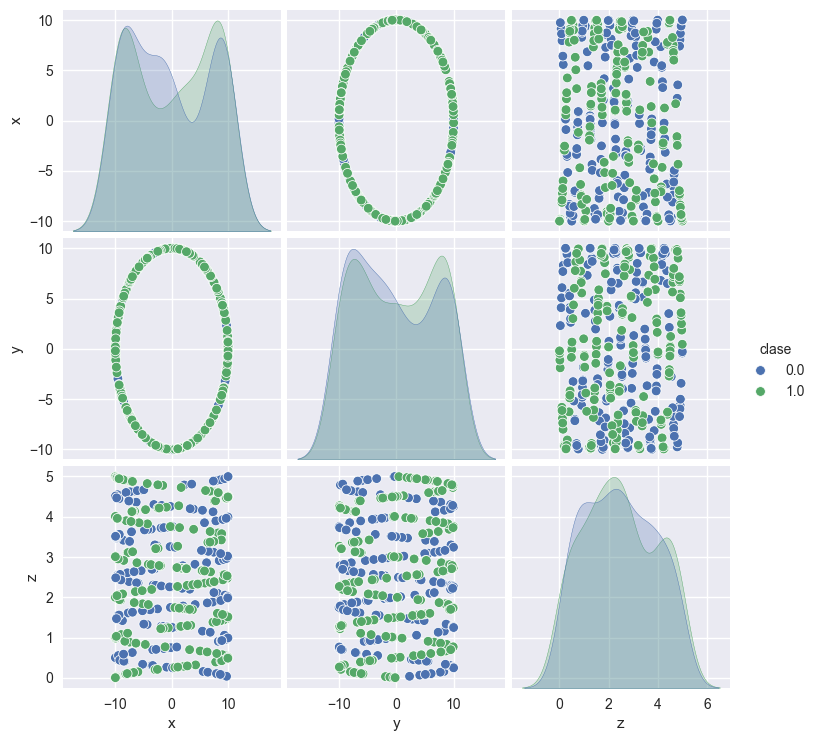

In [ ]:
helices = Dataset("helices", X, y)
df = pd.DataFrame(X, columns=["x", "y", "z"])
df["clase"] = y
sns.pairplot(df, hue="clase")

### El grafico de abajo, pero en 3d?
https://matplotlib.org/stable/gallery/mplot3d/bars3d.html#sphx-glr-gallery-mplot3d-bars3d-py

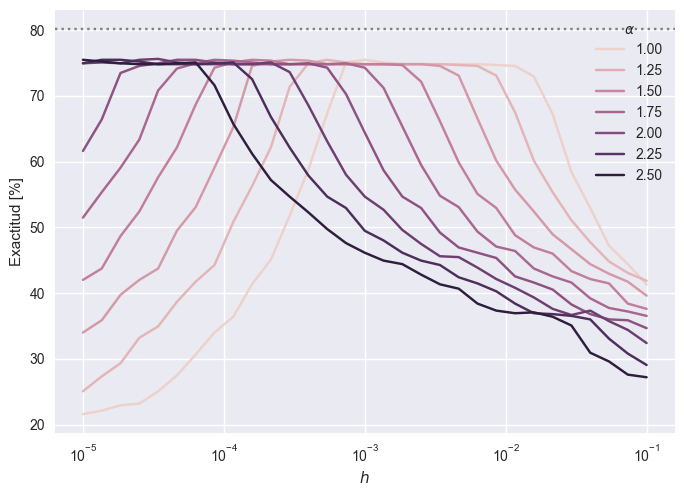

In [ ]:
sns.lineplot(
    data=grilla[grilla.stage == "test"], x="clf__bandwidth", y="score", hue="clf__alpha"
)
plt.xlabel("$h$"), plt.ylabel("Exactitud [%]"), plt.legend(title="$\\alpha$")
plt.axhline(tarea.puntajes.fkdc * 100, linestyle="dotted", color="gray")
plt.xscale("log")

### Sapienza's Swiss Roll
> We use the well-known example coined “Swiss roll”, Figure 1(a) and 1(b). We consider a dataset composed of 4 subsets steaming from independent Normal distributions (restricted to the unit square) with mean $\mu_1 = (.3, .3), \mu_2 = (.3, .7), \mu_3 = (.7, .3), \mu_4 = (.7, .7)$ respectively and constant variance, Figure 1(a). Then, we apply the Swiss Roll transformation, Figure 1(b).

<Axes: xlabel='x', ylabel='y'>

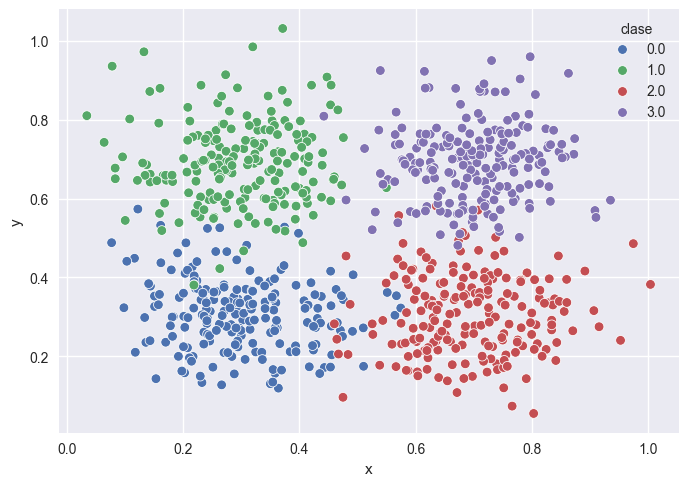

In [ ]:
n_samples = 200
limites = (0.3, 0.7)
centros = [(x, y) for x in limites for y in limites]
varianza = 0.01 * np.identity(len(centros[0]))
Xs = np.vstack(
    [stats.multivariate_normal(mean=c, cov=varianza).rvs(n_samples) for c in centros]
)
ys = np.concatenate([np.ones(n_samples) * i for i in range(len(centros))])
ds = Dataset("swissroll", Xs, ys)
df = pd.DataFrame(Xs, columns = ["x", "y"])
df["clase"] = ys.astype(str)
sns.scatterplot(data=df, x="x", y="y", hue="clase")

In [ ]:
def swissroll(x, y, noise=0.005, return_t=False):
    # Versión modificada de https://homepages.ecs.vuw.ac.nz/~marslast/Code/Ch6/lle.py
    N = len(x)

    t = 2 * np.pi * (1 + 2 * x)
    h = 21 * y
    data = np.vstack((t * np.cos(t), h, t * np.sin(t))) + noise * np.random.randn(
        3, N
    )
    if return_t:
        return np.transpose(data), np.squeeze(t)
    else:
        return np.transpose(data)



In [ ]:
swissed = pd.DataFrame(swissroll(Xs[:, 0], Xs[:, 1]), columns = ["x", "y", "z"])
swissed["clase"] = ys.astype(str)
swissed.sample(10)

,x,y,z,clase
579,-2.481890,5.251821,14.092696,2.0
636,-11.850349,11.364434,9.268832,3.0
426,-9.883703,3.015751,11.106490,2.0
209,-8.465044,11.254329,-5.286610,1.0
85,-1.569489,8.065008,7.900790,0.0
438,-15.718403,2.514799,-0.306587,2.0
622,-13.699413,16.800853,6.689282,3.0
713,-13.750657,17.090183,-8.695828,3.0
414,-2.614936,3.069278,14.078771,2.0
762,1.748279,19.364152,13.905677,3.0


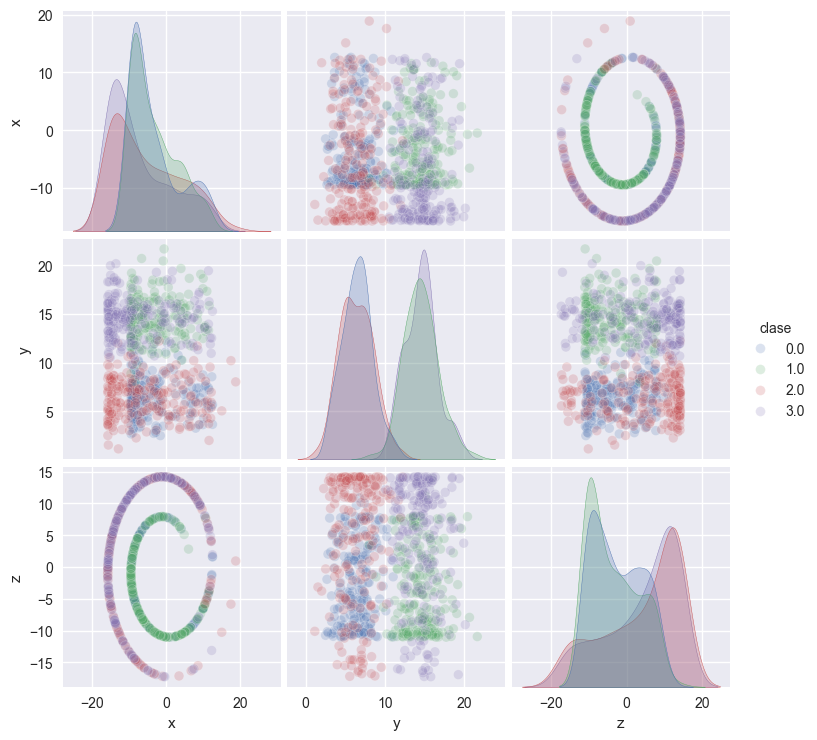

In [ ]:
sns.pairplot(swissed, hue="clase", plot_kws=Bunch(alpha=0.2))